<a href="https://colab.research.google.com/github/afk-2/air-quality-sensor-drift-prediction/blob/main/sensor-drift-forecast-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# ========================
# 1. Load & Inspect Data
# ========================

path = "/content/drive/MyDrive/ML and AI Algorithms Notebooks - MDX/CW 1/"
df = pd.read_csv(path + "AirQualityUCI.csv", sep=";", decimal=",")

# Drop empty unnamed columns
df= df.drop(columns=[col for col in df.columns if col.startswith("Unnamed")])

print("First 5 rows of the dataset:")
display(df.head())

# Make a copy of the original df
df_clean = df.copy()

# Basic Info
df_clean.info()
print(f"\nShape of Dataframe: {df_clean.shape}")

First 5 rows of the dataset:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB

Shape of Dataframe: (9471, 15)


In [ ]:
# Combine 'Date' and 'Time' into a single datetime index
df_clean['Date_Time'] = pd.to_datetime(df_clean['Date'] + ' ' + df_clean['Time'], format="%d/%m/%Y %H.%M.%S")
df_clean.drop(columns=['Date', 'Time'], inplace=True)
df_clean.set_index('Date_Time', inplace=True)

# Add temporal features
df_clean['Hour'] = df_clean.index.hour
df_clean['Day'] = df_clean.index.day
df_clean['Month'] = df_clean.index.month

# Drop Rows Where All Values Are Missing
df_clean = df_clean.dropna(how="all")

print("Data after combining Date and Time:", df.shape)
df_clean.head()

Data after combining Date and Time: (9471, 15)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Day,Month
Date_Time,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18.0,10.0,3.0
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19.0,10.0,3.0
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20.0,10.0,3.0
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21.0,10.0,3.0
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22.0,10.0,3.0


In [ ]:
display(df_clean.describe())

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Day,Month
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,11.498557,15.876884,6.310356
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,6.923182,8.808653,3.438160
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,0.000000,1.000000,1.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,5.000000,8.000000,3.000000
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,11.000000,16.000000,6.000000
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,18.000000,23.000000,9.000000
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,23.000000,31.000000,12.000000


In [ ]:
# ========================
# 2. Clean Data
# ========================

# Check for Nonsensical Values
for col in df_clean.select_dtypes(include=[np.number]).columns:
    print(df_clean[col].value_counts().sort_index())

# Check Count for -200
print((df_clean == -200).sum())

CO(GT)
-200.0    1683
 0.1        33
 0.2        45
 0.3        98
 0.4       160
          ... 
 9.9         1
 10.1        1
 10.2        2
 11.5        1
 11.9        1
Name: count, Length: 97, dtype: int64
PT08.S1(CO)
-200.0     366
 647.0       1
 649.0       1
 655.0       1
 667.0       3
          ... 
 1973.0      1
 1975.0      1
 1982.0      1
 2008.0      1
 2040.0      1
Name: count, Length: 1042, dtype: int64
NMHC(GT)
-200.0     8443
 7.0          1
 8.0          1
 9.0          1
 10.0         1
           ... 
 974.0        1
 1042.0       1
 1084.0       1
 1129.0       1
 1189.0       1
Name: count, Length: 430, dtype: int64
C6H6(GT)
-200.0    366
 0.1        2
 0.2        8
 0.3       10
 0.4       14
         ... 
 50.6       1
 50.7       1
 50.8       1
 52.1       1
 63.7       1
Name: count, Length: 408, dtype: int64
PT08.S2(NMHC)
-200.0     366
 383.0       2
 387.0       1
 388.0       1
 390.0       2
          ... 
 1980.0      1
 1981.0      1
 1983.0      

In [ ]:
# Replace nonsensical -200 values with NaN
for df_clean_col in df_clean.select_dtypes(include=[np.number]).columns:
    df_clean[df_clean_col] = df_clean[df_clean_col].replace(-200, np.nan)

# Drop NMHC(GT) Column Since It Has Mostly NaN Values
df_clean.drop(columns="NMHC(GT)", inplace=True)

# Fill missing values with median for key sensor readings
fill_median_cols = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
for col in fill_median_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Interpolate remaining missing values over time
df_clean.interpolate(method='time', inplace = True)

# Verify
print("Remaining NaN count:")
print(df_clean.isna().sum().sum())

Remaining NaN count:
0


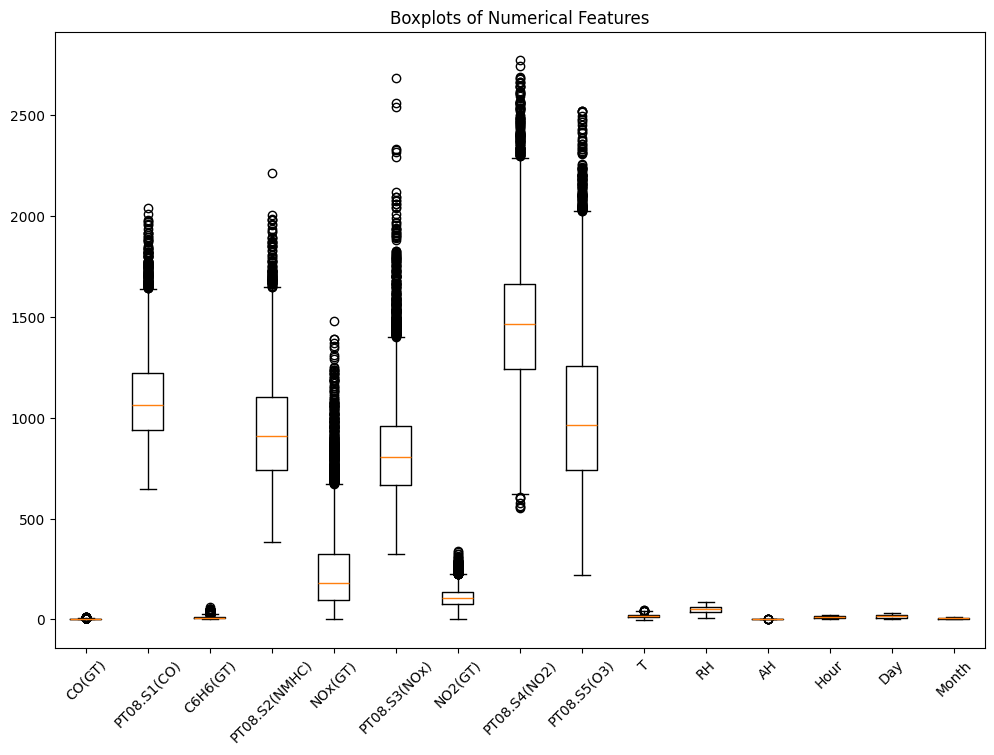

In [ ]:
df_clean_num = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
plt.boxplot(df_clean_num.values, tick_labels=df_clean_num.columns)
plt.xticks(rotation=45)
plt.title("Boxplots of Numerical Features")
plt.show()

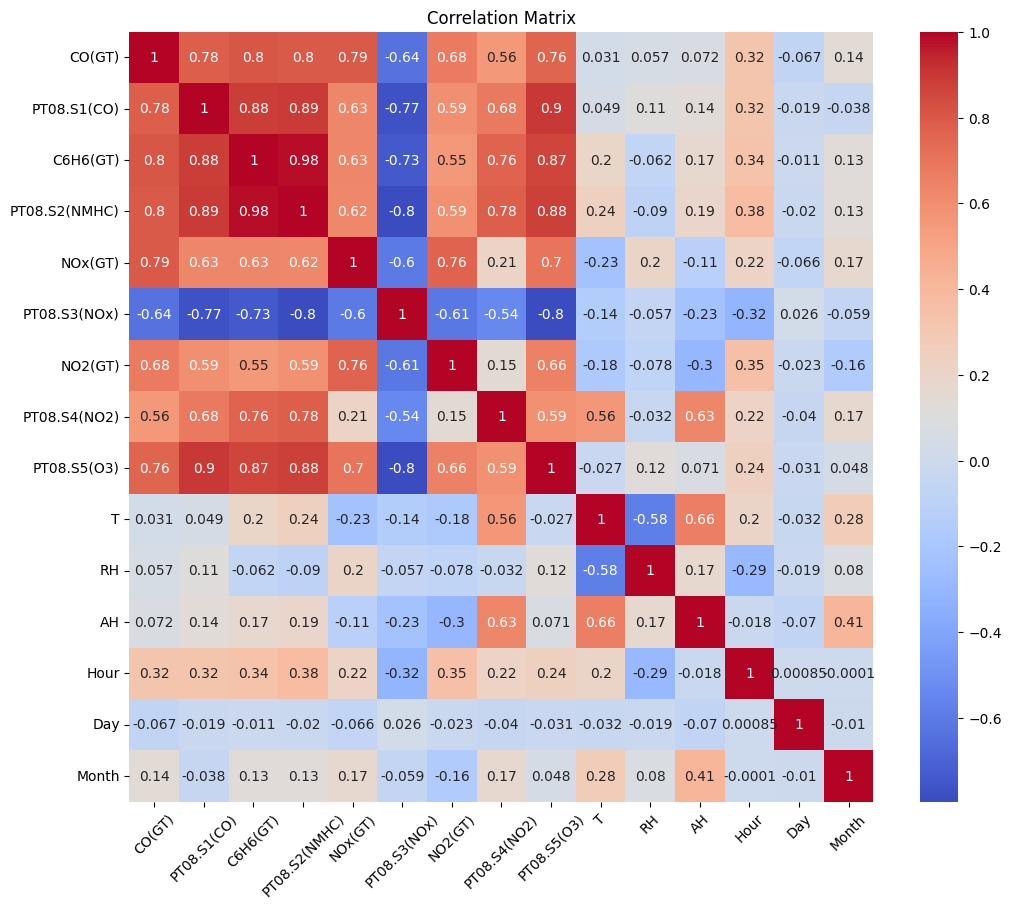

In [ ]:
corr_matrix = df_clean.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Check if the difference between each consecutive rows is 1 hour exact
time_diffs = df_clean.index.to_series().diff().value_counts()
print(time_diffs)

Date_Time
0 days 01:00:00    9356
Name: count, dtype: int64


In [ ]:
# ========================
# 3. Baseline Calibration Model
# ========================

# Use early “fresh” period for calibration
fresh_period = df_clean['2004-03-10':'2004-06-10']
calibration_model = LinearRegression()
calibration_model.fit(
    fresh_period[['PT08.S1(CO)', 'T', 'RH', 'AH']],
    fresh_period['CO(GT)']
)

# Predict expected CO levels
df_clean['CO_Predicted'] = calibration_model.predict(
    df_clean[['PT08.S1(CO)', 'T', 'RH', 'AH']]
)

# Calculate absolute drift error
df_clean['CO_Drift_Error'] = abs(df_clean['CO(GT)'] - df_clean['CO_Predicted'])

df_clean[['CO(GT)', 'CO_Predicted', 'CO_Drift_Error']].head()

,CO(GT),CO_Predicted,CO_Drift_Error
Date_Time,,,
2004-03-10 18:00:00,2.6,3.090855,0.490855
2004-03-10 19:00:00,2.0,2.777185,0.777185
2004-03-10 20:00:00,2.2,3.257256,1.057256
2004-03-10 21:00:00,2.2,3.112175,0.912175
2004-03-10 22:00:00,1.6,2.634721,1.034721


In [ ]:
# ========================
# 4. Feature Engineering
# ========================

# Rolling statistics (24-hour windows)
df_clean['Sensor_Rolling_Mean_24h'] = df_clean['PT08.S1(CO)'].rolling(24).mean()
df_clean['Sensor_Rolling_Std_24h'] = df_clean['PT08.S1(CO)'].rolling(24).std()
df_clean['Error_Rolling_Mean_24h'] = df_clean['CO_Drift_Error'].rolling(24).mean()
df_clean['Temp_Rolling_Mean_24h'] = df_clean['T'].rolling(24).mean()
df_clean['RH_Rolling_Mean_24h'] = df_clean['RH'].rolling(24).mean()

# Drop NaN rows created by rolling windows
df_clean = df_clean.dropna()

In [ ]:
# Create drift flag with binary label: 1 if drifted, 0 if OK
drift_threshold = 1.0
df_clean['Drift_Flag'] = (df_clean['CO_Drift_Error'] > drift_threshold).astype(int)

# Forecast drift 6 hours ahead
df_clean['Drift_Flag_6h_Ahead'] = df_clean['Drift_Flag'].shift(-6)

# Drop last 6 rows that have NaN in shifted target
df_clean = df_clean.dropna(subset=['Drift_Flag_6h_Ahead'])
df_clean['Drift_Flag_6h_Ahead'] = df_clean['Drift_Flag_6h_Ahead'].astype(int)

# Check class distribution for Drift_Flag
print("Drift_Flag distribution:")
print(df_clean['Drift_Flag'].value_counts())
print("\nNormalized (percentage):")
print(df_clean['Drift_Flag'].value_counts(normalize=True))

Drift_Flag distribution:
Drift_Flag
0    7648
1    1680
Name: count, dtype: int64

Normalized (percentage):
Drift_Flag
0    0.819897
1    0.180103
Name: proportion, dtype: float64


In [ ]:
# ========================
# 5. Split Data for Modeling
# ========================

features = df_clean.drop(columns=[
    'CO(GT)',
    'C6H6(GT)',
    'NOx(GT)',
    'NO2(GT)',
    'CO_Predicted',
    'CO_Drift_Error',
    'Drift_Flag',
    'Drift_Flag_6h_Ahead',
    'PT08.S1(CO)'
])

target = df_clean['Drift_Flag_6h_Ahead']

# Train-test split by time
split_date = pd.to_datetime('2005-02-01')
offset = pd.Timedelta(hours=6)

# Split with offset to prevent leakage
X_train = features[features.index < (split_date - offset)]
X_test = features[features.index >= split_date]  # Test starts at split_date
y_train = target[target.index < (split_date - offset)]
y_test = target[target.index >= split_date]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (7825, 15) (1497, 15)


--- Random Forest Model Results ---
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1277
           1       0.37      0.52      0.43       220

    accuracy                           0.80      1497
   macro avg       0.64      0.68      0.66      1497
weighted avg       0.83      0.80      0.81      1497

Confusion Matrix: [[1086  191]
 [ 106  114]]


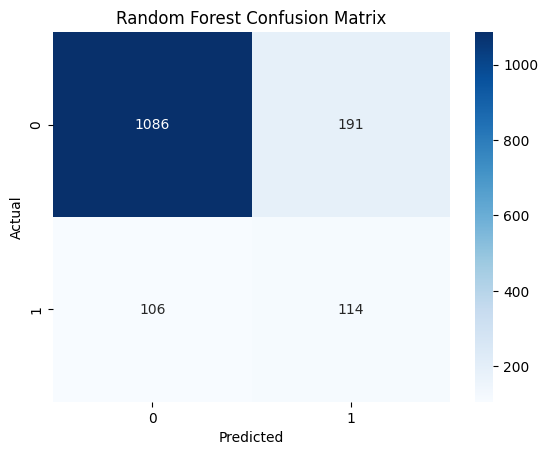

In [ ]:
# ========================
# 6. Random Forest Model
# ========================

rf_model = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test_scaled)

print(f"--- Random Forest Model Results ---")
print(classification_report(y_test, rf_pred))
print(f"Confusion Matrix: {confusion_matrix(y_test, rf_pred)}")

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


--- Top 10 Key Drivers (Feature Importances) ---
                    Feature  Importance
12   Error_Rolling_Mean_24h    0.311191
7                      Hour    0.094251
9                     Month    0.081505
14      RH_Rolling_Mean_24h    0.080432
8                       Day    0.060807
13    Temp_Rolling_Mean_24h    0.051081
11   Sensor_Rolling_Std_24h    0.046149
6                        AH    0.038693
3               PT08.S5(O3)    0.038180
10  Sensor_Rolling_Mean_24h    0.037297


/tmp/ipython-input-2168636596.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


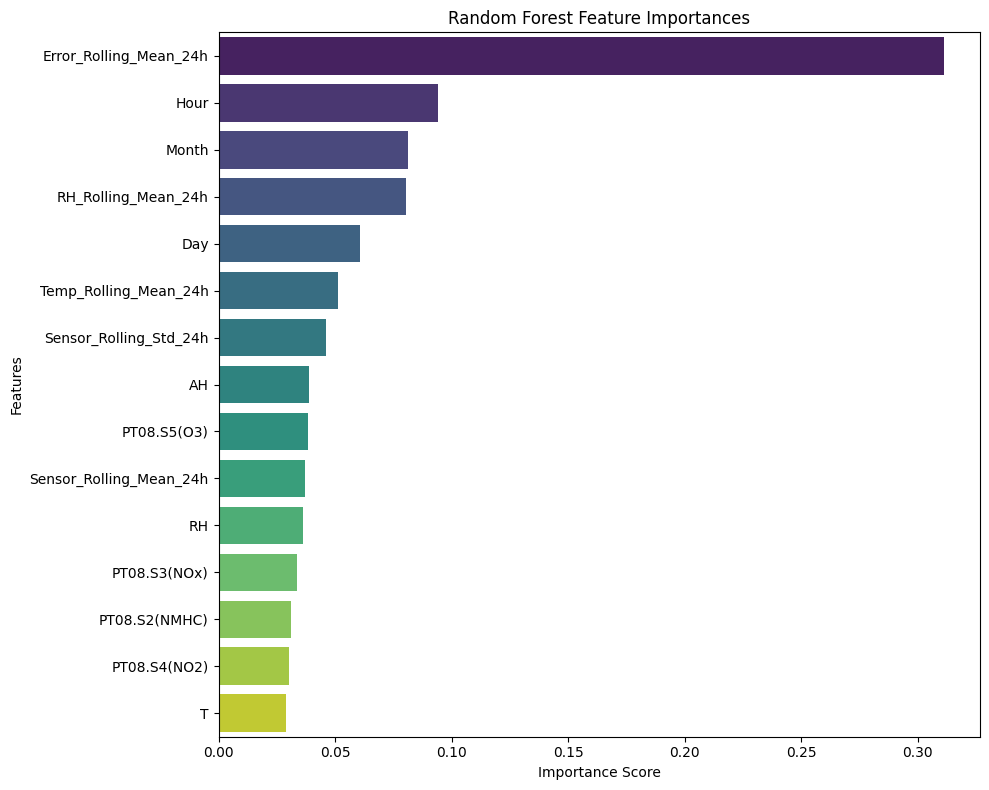

In [ ]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the key drivers
print("\n--- Top 10 Key Drivers (Feature Importances) ---")
print(feature_importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('rf_feature_importances.png')

--- XGB Boost Model Results ---
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1277
           1       0.44      0.32      0.37       220

    accuracy                           0.84      1497
   macro avg       0.66      0.62      0.64      1497
weighted avg       0.82      0.84      0.83      1497

Confusion Matrix: [[1188   89]
 [ 150   70]]


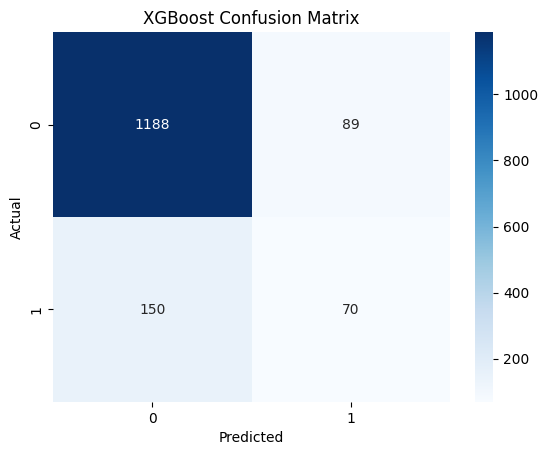

In [ ]:
# ========================
# 7. XGBoost Model
# ========================

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    random_state=42,
)

xgb_model.fit(X_train_scaled, y_train)

xgb_pred = xgb_model.predict(X_test_scaled)

print(f"--- XGB Boost Model Results ---")
print(classification_report(y_test, xgb_pred))
print(f"Confusion Matrix: {confusion_matrix(y_test, xgb_pred)}")

sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()